# Analysis & *.h5 saving of cells and backgrounds
### Johanna Rahm, Sebastian Malkusch
#### Research group Heilemann
#### Institute for Physical and Theoretical Chemistry, Goethe University Frankfurt a.M.
This notebook as to be reloaded before analysing a new group of data!

## Load *.trc files

Choose/insert a directory for the cell files to be searched in (e.g. F:\Marburg\single_colour_tracking\resting). All *.trc  files in the directory will be loaded for the analysis. It is possible to ignore files, by choosing mask words. If a file name containes any mask word, it will not be loaded. Comma separate multiple mask words (e.g. hmm, background, cell02).

In [1]:
from pySPT.widgets.widgetNotebooks import init_save_track_analysis
from pySPT.widgets import hdf5
from pySPT.widgets import widgetTrackAnalysis
from pySPT.widgets import widgetColumnSort
from pySPT.widgets import widgetDirectoryStructure
from pySPT.analysis import coverSlip
from pySPT.analysis import trackAnalysis
from pySPT.analysis import trcFormat
from tqdm import tqdm_notebook as tqdm
import warnings
widget_track_analysis = widgetTrackAnalysis.WidgetTrackAnalysis()
track_analysis = trackAnalysis.TrackAnalysis()
cover_slip = coverSlip.CoverSlip()
display(widget_track_analysis.software_button, widget_track_analysis.dir_box, widget_track_analysis.dir_button)
widget_track_analysis.dir_button.on_click(widget_track_analysis.open_dir)
widget_track_analysis.dir_box.observe(widget_track_analysis.change_dir_box)

RadioButtons(options=('ThunderSTORM', 'rapidSTORM', 'PALMTracer'), value='ThunderSTORM')

Text(value='directory to be searched in', description='directory', placeholder='Type something', style=Descrip…

Button(description='browse', style=ButtonStyle(), tooltip='browse for directory')

In [2]:
def test(event):
    widget_track_analysis.searchSubFolders(widget_track_analysis.dir_name)
    print(widget_track_analysis.file_names)
display(widget_track_analysis.test_button)
widget_track_analysis.test_button.on_click(test)

Button(description='test', style=ButtonStyle(), tooltip='testing')

Choose/insert the complete directory for the roi.log file which contains the cell sizes (e.g. F:\Marburg\single_colour_tracking\resting\roi.log). If no cell size was determined, the camera chip size will be set as the size.

In [3]:
display(widget_track_analysis.roi_box, widget_track_analysis.roi_button)
widget_track_analysis.roi_button.on_click(widget_track_analysis.open_roi)
widget_track_analysis.roi_box.observe(widget_track_analysis.change_roi_box)

Text(value='path of roi', description='roi', placeholder='Type something', style=DescriptionStyle(description_…

Button(description='browse', style=ButtonStyle(), tooltip='browse for roi')

## Camera details

Based on the pixel size, the localization will be transfered from pixel to micrometer.
Based on the amount of pixel, the camera area will be calculated (e.g. 256 * 256=65536 pixel). Camera integration time is needed for MSD calculations.

In [4]:
display(widget_track_analysis.camera_pixel_size_box, widget_track_analysis.camera_pixel_amount_box, widget_track_analysis.camera_integration_time_box)

Text(value='158', description='Pixel size [nm]', placeholder='Type something', style=DescriptionStyle(descript…

Text(value='65536', description='Amount of pixel on the camera', placeholder='Type something', style=Descripti…

Text(value='0.02', description='Camera integration time [s]', placeholder='Type something', style=DescriptionS…

## Parameters for Diffusion Type Analysis

The degree of freedom of the diffusion coefficient D are inserted in the calculation of D (1D = 2, 2D = 4, 3D = 6 dof). The minimal detectable diffusion coefficient is the threshold for the immobile type analysis.
Based on the formular min_track_length * camera_integration_time = n -> tau_threshold = 0.3*n, the tau threshold for diffusion type determination free & confined is set.

In [5]:
display(widget_track_analysis.points_D_fit_box, widget_track_analysis.dof_box, widget_track_analysis.D_min_box, widget_track_analysis.min_track_length_box)

Text(value='4', description='Number of points fitted for D', placeholder='Type something', style=DescriptionSt…

Text(value='4', description='degree of freedom of D', placeholder='Type something', style=DescriptionStyle(des…

Text(value='0.0065', description='Minimal detectable D  [μm²/s]', placeholder='Type something', style=Descript…

Text(value='20', description='Min track length', placeholder='Type something', style=DescriptionStyle(descript…

The diffusion type analysis can be based on the track id or seg id of the trc file. A track can contain multiple segmentations with different diffusion models that will be averaged. Therefore running the analysis on a segment level is recommended. For PALMTracer .trc files no seg id is available and the track id has to be chosen.

In [6]:
display(widget_track_analysis.trajectory_id_button)

RadioButtons(options=('seg id', 'track id'), value='seg id')

## Parameters for Hidden Markov Modeling

Check the box to enable hidden markov modeling. A .trc file for the ermine cluster will be saved in the pySPT/hmm folder. The hidden markov modeling is applied to the track id to observe state transformations. Choose a min track length to investigate the system (at least 2).

In [7]:
display(widget_track_analysis.hmm_check_box, widget_track_analysis.min_track_length_hmm_box)

Checkbox(value=True, description='Save .trc file')

Text(value='2', description='Min track length', placeholder='Type something', style=DescriptionStyle(descripti…

## Run Analysis

In [8]:
widget_dir_structure = widgetDirectoryStructure.WidgetDirStructure()#??

warnings.filterwarnings('ignore')
display(widget_track_analysis.run_button)
def run_analysis(event):
    widget_track_analysis.create_clear_output()
    widget_track_analysis.searchSubFolders(widget_track_analysis.dir_name)
    if widget_track_analysis.got_dir:
        cover_slip.software, cover_slip.min_track_length_type, cover_slip.min_track_length_hmm, cover_slip.dt, cover_slip.pixel_size, cover_slip.pixel_amount, cover_slip.dof, cover_slip.D_min, cover_slip.roi_file, cover_slip.cell_files, cover_slip.points_fit_D, cover_slip.seg_id = widget_track_analysis.software_button.value, widget_track_analysis.min_track_length_box.value, widget_track_analysis.min_track_length_hmm_box.value, widget_track_analysis.camera_integration_time_box.value, widget_track_analysis.camera_pixel_size_box.value, widget_track_analysis.camera_pixel_amount_box.value, widget_track_analysis.dof_box.value, widget_track_analysis.D_min_box.value, widget_track_analysis.roi_name, widget_track_analysis.file_names, widget_track_analysis.points_D_fit_box.value, widget_track_analysis.trajectory_id_button.value      
        for cell_idx in range(len(cover_slip.cell_files)):
            if widget_track_analysis.software_button.value != "PALMTracer":
                if widget_track_analysis.software_button.value == "ThunderSTORM":
                    widget_column_sort = widgetColumnSort.WidgetColumnSort(cover_slip.cell_files[cell_idx], widget_track_analysis.software_button.value, ['"track.id"' , '"x [nm]"', '"y [nm]"', '"frame"', '"intensity [photon]"', '"seg.id"'])
                elif widget_track_analysis.software_button.value == "rapidSTORM":
                    widget_column_sort = widgetColumnSort.WidgetColumnSort(cover_slip.cell_files[cell_idx], widget_track_analysis.software_button.value, ['"track.id"', '"Position-0-0"', '"Position-1-0"', '"Amplitude-0-0"', '"ImageNumber-0-0"', '"seg.id"'])
                widget_column_sort.check_header()
                if widget_column_sort.correct_header:
                    widget_column_sort.run_column_sort()
                    cover_slip.column_orders.append(widget_column_sort.column_order)
        cover_slip.create_cells()  
        track_analysis.cell_sizes = [cell.size for cell in cover_slip.cells]
        track_analysis.cell_trajectories = cover_slip.cell_trajectories
        track_analysis.run_statistics_no_filter()
    else:
        widget_track_analysis.warning_trc_file()
    widget_track_analysis.cells = cover_slip.cells
    for cell in cover_slip.cells:
        print("sigma dyn", cell.sigma_dyn)
widget_track_analysis.run_button.on_click(run_analysis)

suffix output PALMTracer .trc
suffix output PALMTracer .trc


Conversion successful.
<class 'list'>
<class 'list'>
[3, 1, 61.8904609680176, 145.246322631836, 0, 28852.779785156297, 3]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




cell tau 0.12



Analysis took 26.208670616149902 s
24.4 % are immobile
19.4 % are confined
55.9 % are free
Total trajectories: 712
sigma dyn 0.038577823887928776


## Plot diffusion histogram

Plot the normalized frequency in % against the diffusion coefficients (semi log scale). Diffusion coefficients <= 0 are neglected, because the logarithm is not defined in this interval.

In [9]:
display(widget_track_analysis.bin_size_box)

Text(value='0.1', description='bin size', placeholder='size for log10(D) histogram', style=DescriptionStyle(de…

Button(description='plot', style=ButtonStyle(), tooltip='plot diffusion histogram')

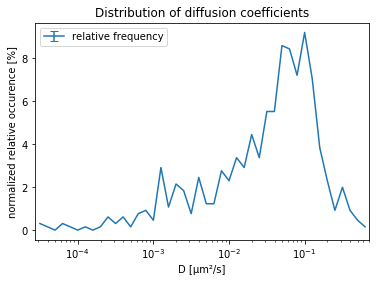

In [10]:
def plot_diffusions(event):
    widget_track_analysis.create_clear_output()
    display(widget_track_analysis.plot_diff_button)
    track_analysis.run_plot_diffusion_histogram(widget_track_analysis.bin_size_box.value)
display(widget_track_analysis.plot_diff_button)
widget_track_analysis.plot_diff_button.on_click(plot_diffusions)

## Choose trajectory to plot

Choose a cell. If one wants to plot multiple times, choose a new cell and/or trajectory reload the plotting cell by clicking in the cell and pressing strg+enter.

In [11]:
def dropdown(event):
    widget_track_analysis.cell_options = widget_track_analysis.get_cell_names(cover_slip.cells)
widget_track_analysis.run_button.on_click(dropdown)
display(widget_track_analysis.drop_down_cells)

Dropdown(description='Number:', options=(), value=None)

Choose a trajectory.

In [12]:
def dropdown(event):      
    for cell in cover_slip.cells:
        if cell.name == widget_track_analysis.drop_down_cells.value:
            target_cell = cover_slip.cells.index(cell)
            trajectory_indexes = [i+1 for i, _ in enumerate(cover_slip.cell_trajectories[target_cell])]
            widget_track_analysis.trajectory_options = trajectory_indexes
            widget_track_analysis.drop_down_trajectories.options = widget_track_analysis.trajectory_options
widget_track_analysis.drop_down_cells.observe(dropdown)
display(widget_track_analysis.drop_down_trajectories)

Dropdown(description='Number:', options=(), value=None)

Button(description='plot', style=ButtonStyle(), tooltip='plot chosen trajectory')

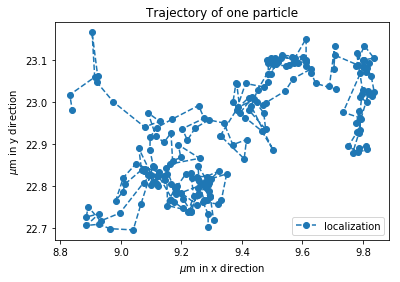

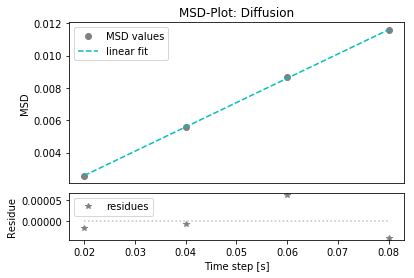

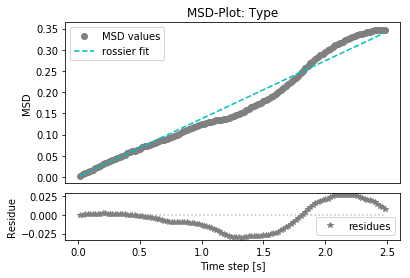

Number: 3
Trajectory length: 208
Diffusion coefficient: 0.03756122837592758 μm²/s
MSD0: -0.00042068070990826205 μm²
chi² linear fit: 6.892730434886307e-07 μm⁴
Type immobile: False
Analyse successful? True
chi² rossier fit: 0.1856390146676524 μm⁴
Type confined: False
Type free: True
D_conf: 0.03428145413986308 μm²/s
r_conf: 76.11106277346839 μm
tau: 56326.80042171613 s
tau threshold: 0.12 s


In [13]:
def plot_particle(event):
    widget_track_analysis.create_clear_output()
    display(widget_track_analysis.plot_button)
    cover_slip.plot_trajectory(widget_track_analysis.drop_down_cells.value, widget_track_analysis.drop_down_trajectories.value)
display(widget_track_analysis.plot_button)
widget_track_analysis.plot_button.on_click(plot_particle)

## Save

For each cell a .h5 file will be created, containing all information of the trajectories (unfiltered).

In [14]:
def save_analysis(event):    
    for cell_index in tqdm(range(0, len(cover_slip.cells))):
        init_save_track_analysis(cover_slip, cell_index, track_analysis, widget_track_analysis.points_D_fit_box.value)
display(widget_track_analysis.save_button)
widget_track_analysis.save_button.on_click(save_analysis)

Button(description='save', style=ButtonStyle(), tooltip='save entire analysis')

AttributeError: 'CoverSlip' object has no attribute 'tau_threshold_min_length'